# Chapter 3 Linear Regression Applied Exercises

## 8. This question involves the use of simple linear regression on the *Auto* data set.

### (a) Use the *sm.OLS()* function to perform a simple linear regression with *mpg* as the response and *horsepower* as the predictor. Use the *summarize()* function to print the results. Comment on the output. 

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from patsy import dmatrices
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.anova import anova_lm


In [2]:
# Import data from csv
df = pd.read_csv(r'C:\Users\User-PC\Documents\GitHub\Introduction-to-Statistical-Learning\Data sets\Auto.csv')

In [3]:
# Notice that there is something fishy going on in the 'horsepower' column. There are '?' in some of the rows,
# and the type is object. We will need to fix that.
df['horsepower'].unique()

array(['130', '165', '150', '140', '198', '220', '215', '225', '190',
       '170', '160', '95', '97', '85', '88', '46', '87', '90', '113',
       '200', '210', '193', '?', '100', '105', '175', '153', '180', '110',
       '72', '86', '70', '76', '65', '69', '60', '80', '54', '208', '155',
       '112', '92', '145', '137', '158', '167', '94', '107', '230', '49',
       '75', '91', '122', '67', '83', '78', '52', '61', '93', '148',
       '129', '96', '71', '98', '115', '53', '81', '79', '120', '152',
       '102', '108', '68', '58', '149', '89', '63', '48', '66', '139',
       '103', '125', '133', '138', '135', '142', '77', '62', '132', '84',
       '64', '74', '116', '82'], dtype=object)

In [4]:
# Change the index to name and drop the '?' in 'horsepower', then convert the column to numeric values
df = df.set_index('name')
df = df[pd.to_numeric(df['horsepower'], errors='coerce').notnull()]
df['horsepower'] = pd.to_numeric(df['horsepower'])

In [5]:
# Create design matrices. There is a nice library called patsy to do this. 
# https://en.wikipedia.org/wiki/Design_matrix
y, X = dmatrices('mpg ~ horsepower', data=df, return_type = 'dataframe')

# Create and fit the model
model = sm.OLS(y,X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     599.7
Date:                Thu, 07 Mar 2024   Prob (F-statistic):           7.03e-81
Time:                        20:28:22   Log-Likelihood:                -1178.7
No. Observations:                 392   AIC:                             2361.
Df Residuals:                     390   BIC:                             2369.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     39.9359      0.717     55.660      0.0

### i) Is there a relationship between the predictor and the response?

Yes, there is a relationship. The p-value is less than 0.05, suggesting there is evidence to reject the null hypotheses where we assume $\beta$$_1$ = 0.

### ii) How strong is the relationship between the predictor and the response?

For each increase of one unit of horspower, the miles per gallon will decrease by 0.1578.

### iii) Is the relationship between the predictor and the response positive or negative?

Negative. The coefficient has a negative sign. If the horsepower increases, the miles per gallon will decrease. 

### iv) What is the predicted *mpg* associated with a *horsepower* of 98? What are the associated confidence and prediction intervals?

In [6]:
# There are a few ways to get predictions
# 1. The easy way is to create a formula with the coeficients
horsepower_pred = 98
y_pred1 = results.params[0] + results.params[1] * horsepower_pred

# 2. The second way is to create a design matrix and the use statsmodels to predict. This way is less intuitive to me
# but it allows other nice functions.

# Create a new design matrix with values we want to predict
X_pred_linear = pd.DataFrame({'intercept' : [1], 'horsepower' : [98]})
y_pred_linear = results.predict(X_pred_linear)
y_pred_linear_1 = np.array(results.predict(X))
new_y = results.get_prediction(X_pred_linear)
print(new_y.predicted)

print(new_y.conf_int(obs=True, alpha=0.5))     

[24.46707715]
[[21.15076455 27.78338976]]


The predicted value for a horsepower of 98 is 24.47 miles per gallon, with the 95% confidence interval of 21.15-27.78 miles per gallon. 

### b) Plot the response and the predictor in a new set of axes *ax*. Use the *ax.axline()* method for the *abline()* function defined in the lab to display the least squares regression line. 

In [7]:
# Define a function to plot a straight line
def abline(ax,b,m,*args,**kwargs):
    """Add a line with slope m and intercept b to ax"""
    xlim = ax.get_xlim()
    ylim = [m*xlim[0] + b, m*xlim[1] + b]
    ax.plot(xlim,ylim, *args, **kwargs)

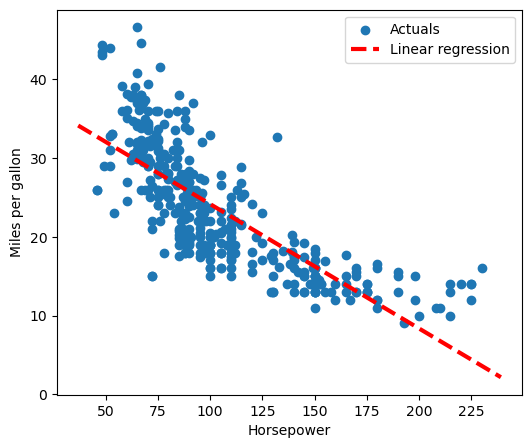

In [8]:
# Plot the data and add the straight line to the plot
fig, ax = plt.subplots(figsize = (6,5))
ax.scatter(x = df['horsepower'], y = df['mpg'])
ax.set_xlabel('Horsepower')
ax.set_ylabel('Miles per gallon')
abline(ax, results.params[0], results.params[1], 'r--', linewidth = 3)
ax.legend(['Actuals','Linear regression'])

### c) Produce some of the diagnostic plots of the least squares regression fit as described in the lab. Comment on any problems you see with the fit. 

In [9]:
# Let's define functions to draw diagnostic plots

def diag_plots(results_x,*args,**kwargs):
    """Returns diagnostic plots (residual plot, Q-Q, standardised residual plot, and a leverage plot) to diagnose linear regression fits"""
    # Define which model results this function should use and calculate the studenstised residuals
    results = results_x
    df_res = results.outlier_test()

    # Define a subplot with 2 rows and 2 columns
    fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2,2,figsize=(15,10))
    
    # Residual plot
    sns.regplot(x=results.fittedvalues, y= df_res['student_resid'], lowess=True, ax = ax1)
    ax1.set_ylim(-4,4)
    ax1.axhline(y=3, linewidth = 0.5, linestyle = 'dashed', color = 'red')
    ax1.axhline(y=-3, linewidth = 0.5, linestyle = 'dashed', color = 'red')
    ax1.set_xlabel('Fitted values')
    ax1.set_ylabel('Studentised residuals')
    ax1.set_title('Studentised residual plot')
    
    # Q-Q normal plot
    ax2 = stats.probplot(results.resid, dist='norm', plot=ax2)
    
    # Standardised residuals
    sns.regplot(x=results.fittedvalues, y=np.sqrt(df_res['student_resid']), lowess=True, ax = ax3)
    ax3.set_xlabel('Fitted values')
    ax3.set_ylabel('Standardised residuals')
    ax3.set_title('Standardised residual plot')
    
    # Leverage plot
    infl = results.get_influence()
    ax4.scatter(infl.hat_matrix_diag,df_res['student_resid'])
    ax4.set_xlabel('Leverage')
    ax4.set_ylabel('Studentised residuals')
    ax4.set_title('Leverage plot')

    

c:\Users\User-PC\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


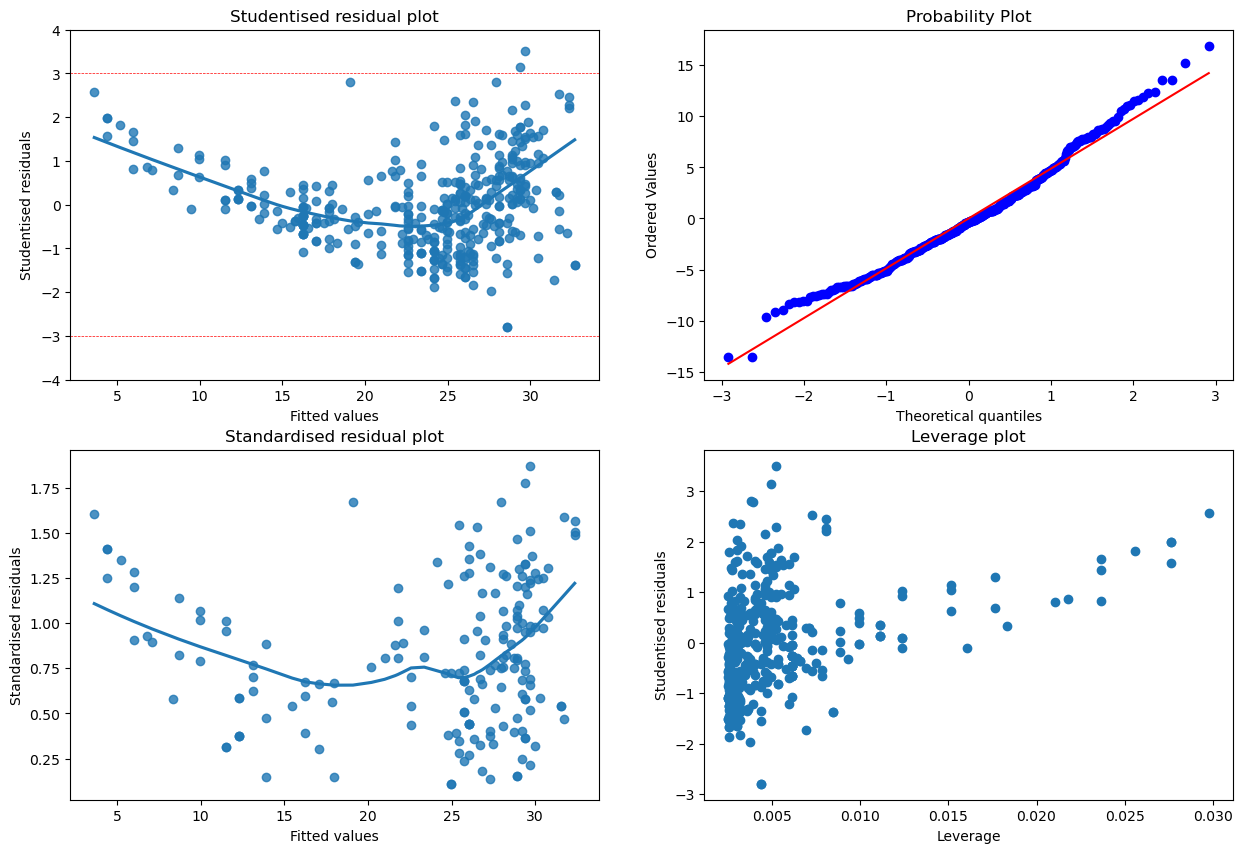

In [10]:
diag_plots(results)

We can make the following observations:

**Studentised residual plot:** The residual plot shows a U shape. This indicates that the relationship of the predictor and response is non-linear. This can also be clearly seen in the plot of horsepower versus miles per gallon. The linear model does not account for all of the reducible variance. There also appears to be two outliers, since the studentised residuals are above 3. 

**Q-Q plot:** The Q-Q plot shows a non-normal distribution of the data.

**Standardised residuals** 

**Leverage plot** The leverage plot shows that there are outliers in the data.



## 9. This question involves the use of multiple linear regression on the *Auto* data set. 

### (a) Produce a scatterplot matrix which includes all of the variables in the data set.

c:\Users\User-PC\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


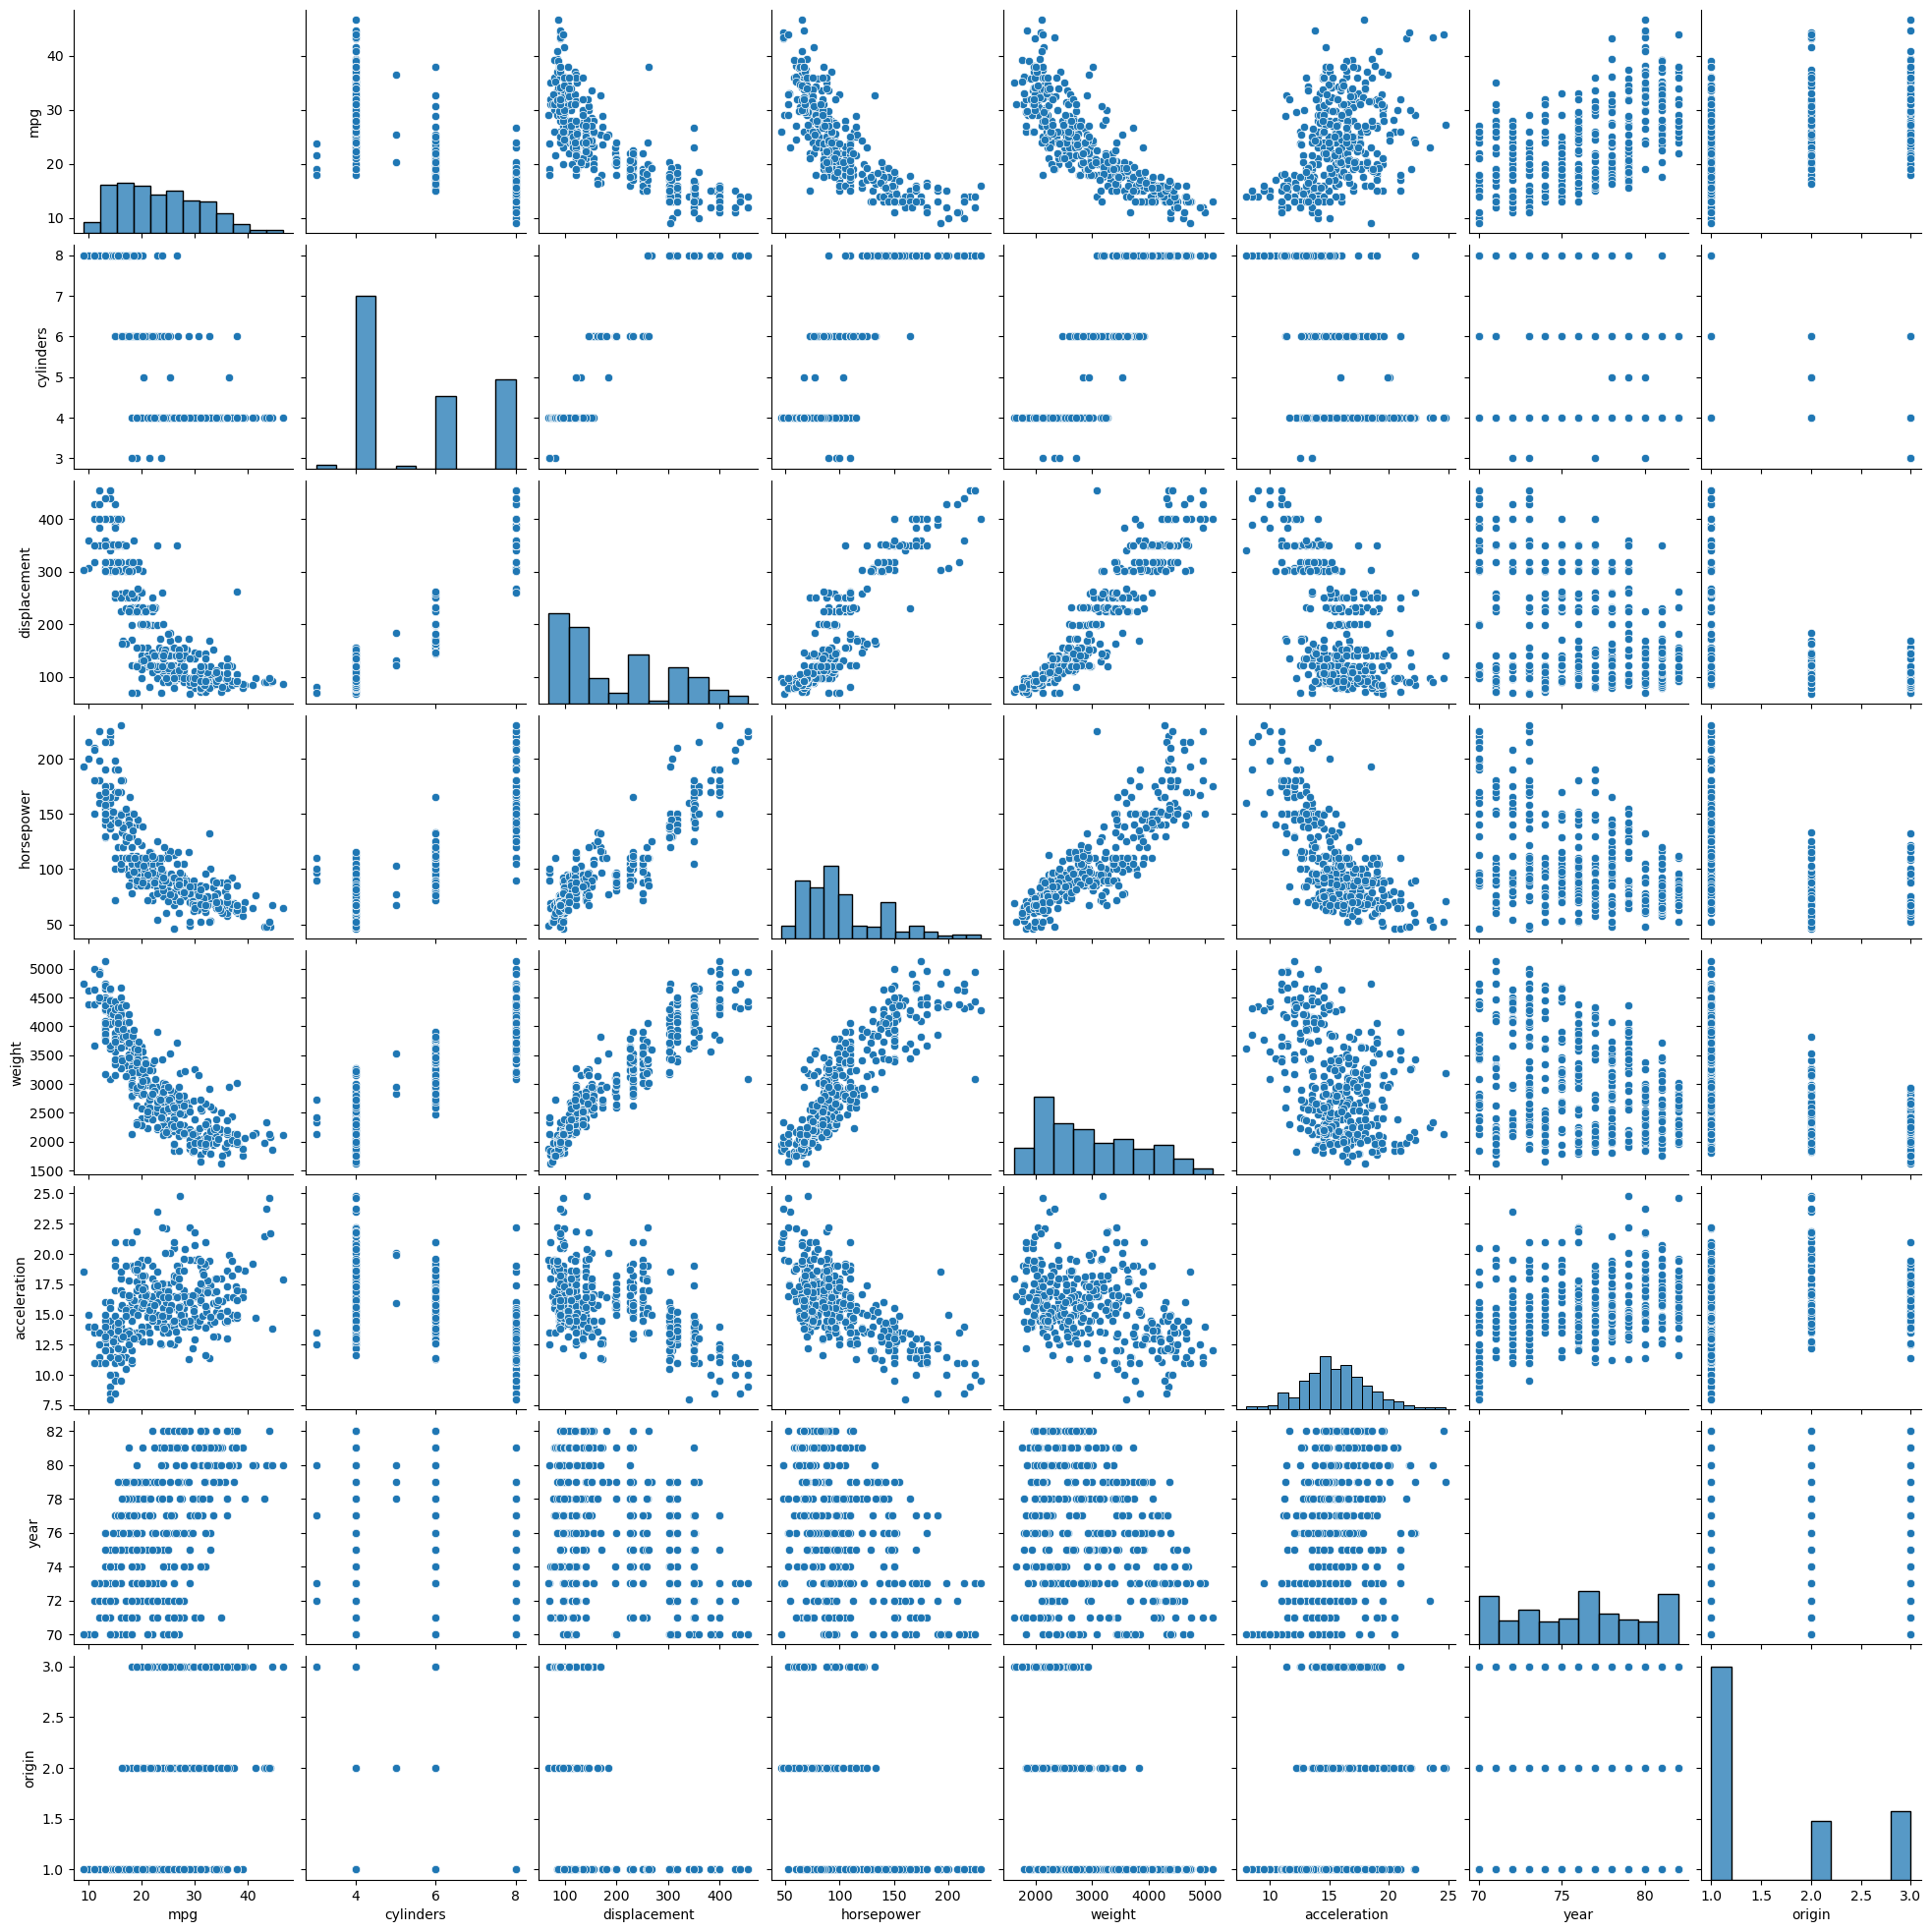

In [11]:
# Create a pairplot matrix
sns.pairplot(df)

### (b) Compute the matrix of correlations between the variables using the *DataFrame.corr()* method.

<Axes: >

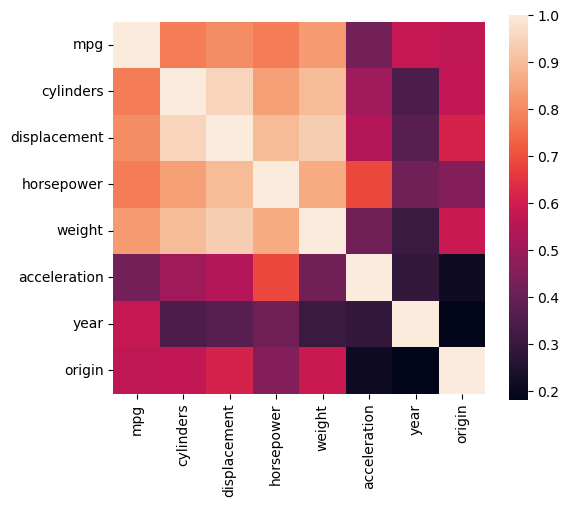

In [12]:
# Define the correlation matrix
corr_matrix = df.corr().abs()

# Plot the result in a heatmap
fig, ax = plt.subplots(figsize = (6,5))
sns.heatmap(corr_matrix, vmax=1, square=True)

### (c) Perform a multiple linear regression with mpg as the response and all other variables except name as the predictors. Use the summary() function to print the results. Comment on the output. For instance:
i) Is there a relationship between the predictors and the response?

ii) Which predictors appear to have a statistically significant relationship to the response?

iii) What does the coefficient for the year variable suggest?

In [13]:
# Define the model equation
f = 'mpg ~ cylinders + displacement + horsepower + weight + acceleration + year + C(origin)'

# Define the design matrix
y,X1 = dmatrices(f, df, return_type='dataframe')

# Define the model
model1 = sm.OLS(y,X1)
results1 = model1.fit()

print(results1.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     224.5
Date:                Thu, 07 Mar 2024   Prob (F-statistic):          1.79e-139
Time:                        20:28:37   Log-Likelihood:                -1020.5
No. Observations:                 392   AIC:                             2059.
Df Residuals:                     383   BIC:                             2095.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -17.9546      4.677     -3.

### i) Is there a relationship between the predictors and the response?

Yes, there is a relationship between the predictors and the response. The F-value is 224. Since this is far larger than one, there is compelling evidence to reject the null hypothesis which states that there are no relationship between the predictors and the response. 

### ii) Which predictors appear to have a statistically significant relationship to the response?

The following predictors have p-values less than 0.05, which would suggest that there is a statistically significant relationship between the predictor and response:

In [14]:
# Print the p-values which are less than 0.05.
results1.pvalues[results1.pvalues < 0.05].sort_values()

year              2.332943e-40
weight            6.375633e-22
C(origin)[T.3]    3.933208e-07
C(origin)[T.2]    4.720373e-06
Intercept         1.445124e-04
displacement      1.862685e-03
dtype: float64

### iii) What does the coefficient for the year variable suggest?

The coefficient for the *year* variable is 0.777. As the year increases, the miles per gallon also increases. New cars are more fuel efficient than older ones. Specifically, for each increase in the year of manufacture, we predict that the miles per gallon will increase with 0.777. 

### (d) Produce some of the diagnostic plots of the linear regression fit as described in the lab. Comment on any problems you see with the fit. Do the residual plots suggest any unusually large outliers? Does the leverage plot identify any observations with unususally high leverage?

c:\Users\User-PC\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


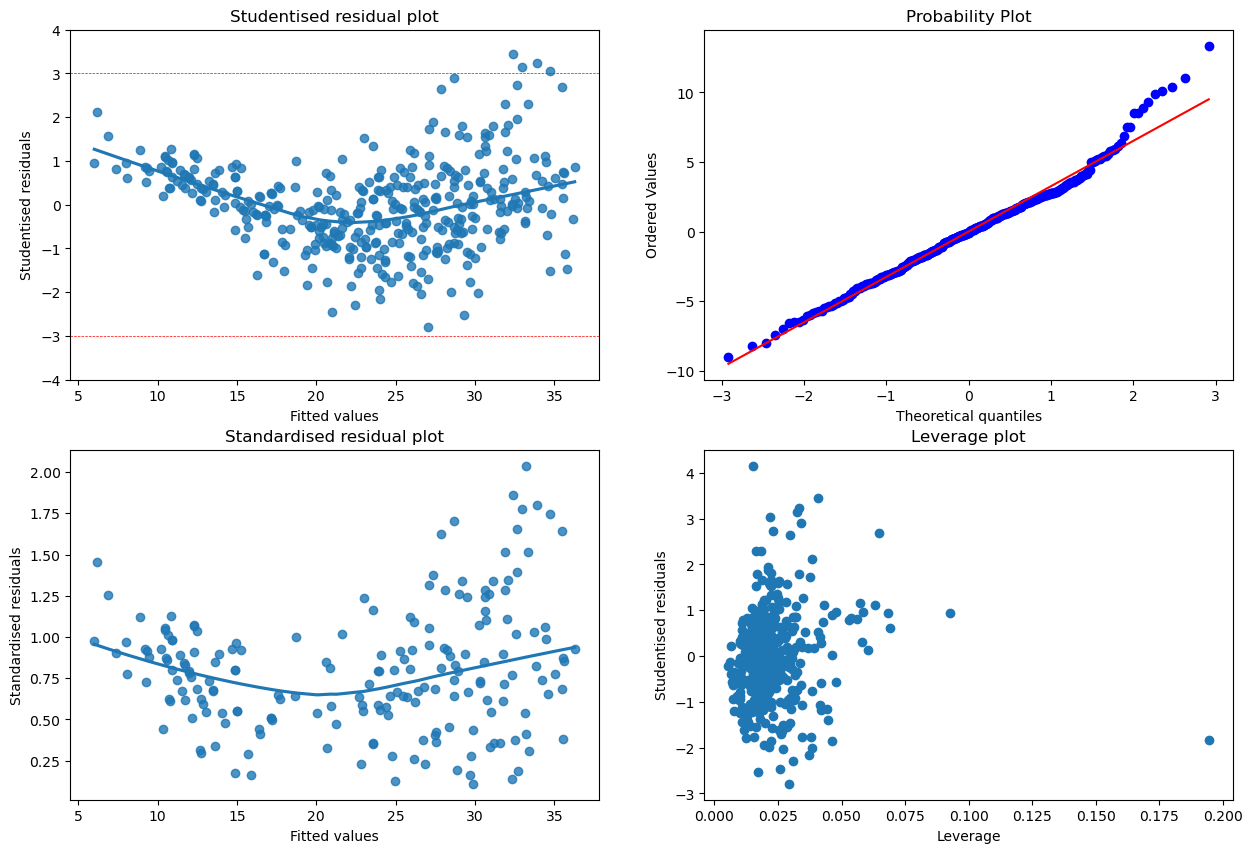

In [15]:
diag_plots(results1)

**Studentised residual plot** There is a patter to the studentised residual plot. It has a U-shape. This indicates that the model has some non-linearity.

**Q-Q plot** The Q-Q plot suggests non-normal data (possibly some outliers)

**Standardised residual plot** The non-linearity is slightly reduced by the square root transform.

**Leverage plot** The leverage plot suggest one point has very high leverage which could affect the fit.

**Multicollinearity** The output warns of possible multicollinearity. We can calculate the variance inflation factors to test for this.

In [16]:
vals = [variance_inflation_factor(X1,i) for i in range (1,X1.shape[1])]
vif = pd.DataFrame({'vif':vals}, index = X1.columns[1:])
print(vif)

                      vif
C(origin)[T.2]   1.649271
C(origin)[T.3]   1.762692
cylinders       10.737771
displacement    22.937950
horsepower       9.957265
weight          11.074349
acceleration     2.625906
year             1.301373


We notice the variance inflation factor are low for a few variables, such as origin, acceleration, and year. We can deal with this by dropping variables or combining variables. This will not be done from now on, but in the future we can see if the fit is improved by this method. 

### (e) Fit some models with the interactions described in the lab. Do any interactions appear to be statistically significant?

In [17]:
# Define the model formula
f2 = 'mpg ~ cylinders + displacement + horsepower + weight + acceleration + year + C(origin) \
    + cylinders*displacement \
    + cylinders*horsepower \
    + cylinders*weight \
    + cylinders*acceleration \
    + cylinders*year \
    + displacement*horsepower \
    + displacement*weight \
    + displacement*acceleration \
    + displacement*year \
    + horsepower*weight \
    + horsepower*acceleration \
    + horsepower*year \
    + weight*weight \
    + weight*acceleration \
    + weight*year \
    + acceleration*year'

# Define the design matrix
# Define the design matrix
y,X2 = dmatrices(f2, df, return_type='dataframe')

# Define and fit the model
model2 = sm.OLS(y,X2)
results2 = model2.fit()

print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     121.8
Date:                Thu, 07 Mar 2024   Prob (F-statistic):          1.66e-156
Time:                        20:28:38   Log-Likelihood:                -939.16
No. Observations:                 392   AIC:                             1926.
Df Residuals:                     368   BIC:                             2022.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [18]:
# Print the p-values which are less than 0.05.
results2.pvalues[results2.pvalues < 0.05].sort_values()

cylinders:displacement       0.006867
C(origin)[T.2]               0.008352
C(origin)[T.3]               0.017020
displacement:year            0.019580
acceleration                 0.028365
displacement:weight          0.029446
acceleration:year            0.036595
displacement:acceleration    0.049588
dtype: float64

### (f) Try a few different transformations of the variables, such as log(X), $\sqrt{X}$, $X^2$. Comment on your findings.

In [19]:
# Define the model formula
f_log = 'mpg ~ np.log(cylinders) + np.log(displacement) + np.log(horsepower) + np.log(weight) + np.log(acceleration) + np.log(year) + C(origin) \
    + np.log(cylinders*displacement) \
    + np.log(cylinders*horsepower) \
    + np.log(cylinders*weight) \
    + np.log(cylinders*acceleration) \
    + np.log(cylinders*year) \
    + np.log(displacement*horsepower) \
    + np.log(displacement*weight) \
    + np.log(displacement*acceleration) \
    + np.log(displacement*year) \
    + np.log(horsepower*weight) \
    + np.log(horsepower*acceleration) \
    + np.log(horsepower*year) \
    + np.log(weight*weight) \
    + np.log(weight*acceleration) \
    + np.log(weight*year) \
    + np.log(acceleration*year)'

# Define the design matrix
y,X_log = dmatrices(f_log, df, return_type='dataframe')

# Define the model and fit
model_log = sm.OLS(y,X_log)
results_log = model_log.fit()

print(results_log.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     267.9
Date:                Thu, 07 Mar 2024   Prob (F-statistic):          9.73e-152
Time:                        20:28:38   Log-Likelihood:                -991.47
No. Observations:                 392   AIC:                             2001.
Df Residuals:                     383   BIC:                             2037.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

c:\Users\User-PC\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


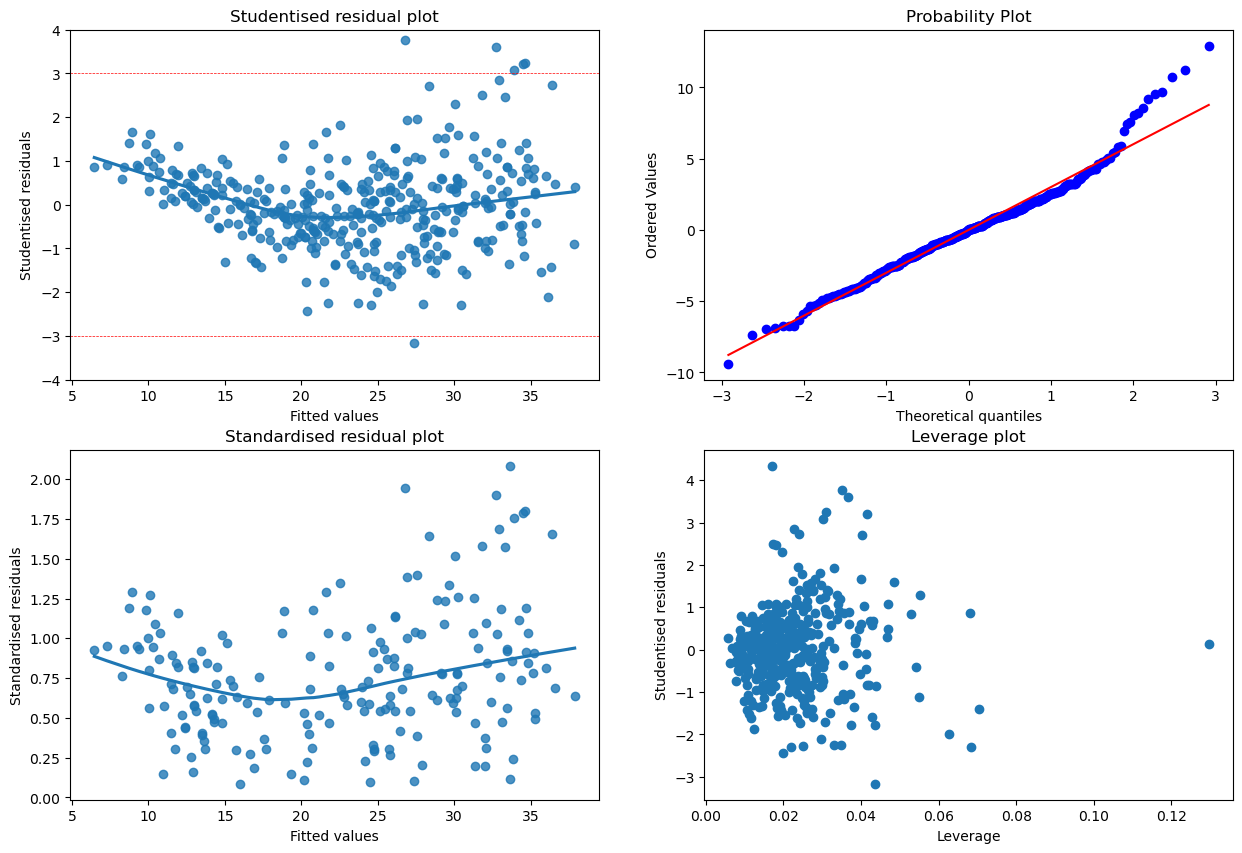

In [20]:
# Draw diagnostic plots
diag_plots(results_log)

In [21]:
# Define the model formula
f_log_1 = 'np.log(mpg) ~ np.log(cylinders) + np.log(displacement) + np.log(horsepower) + np.log(weight) + np.log(acceleration) + np.log(year) + C(origin) \
    + np.log(cylinders*displacement) \
    + np.log(cylinders*horsepower) \
    + np.log(cylinders*weight) \
    + np.log(cylinders*acceleration) \
    + np.log(cylinders*year) \
    + np.log(displacement*horsepower) \
    + np.log(displacement*weight) \
    + np.log(displacement*acceleration) \
    + np.log(displacement*year) \
    + np.log(horsepower*weight) \
    + np.log(horsepower*acceleration) \
    + np.log(horsepower*year) \
    + np.log(weight*weight) \
    + np.log(weight*acceleration) \
    + np.log(weight*year) \
    + np.log(acceleration*year)'

# Define the design matrix
y,X_log_1 = dmatrices(f_log_1, df, return_type='dataframe')

# Define the model and fit
model_log_1 = sm.OLS(y,X_log_1)
results_log_1 = model_log_1.fit()

print(results_log_1.summary())

                            OLS Regression Results                            
Dep. Variable:            np.log(mpg)   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     390.2
Date:                Thu, 07 Mar 2024   Prob (F-statistic):          6.65e-179
Time:                        20:28:39   Log-Likelihood:                 301.01
No. Observations:                 392   AIC:                            -584.0
Df Residuals:                     383   BIC:                            -548.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

c:\Users\User-PC\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


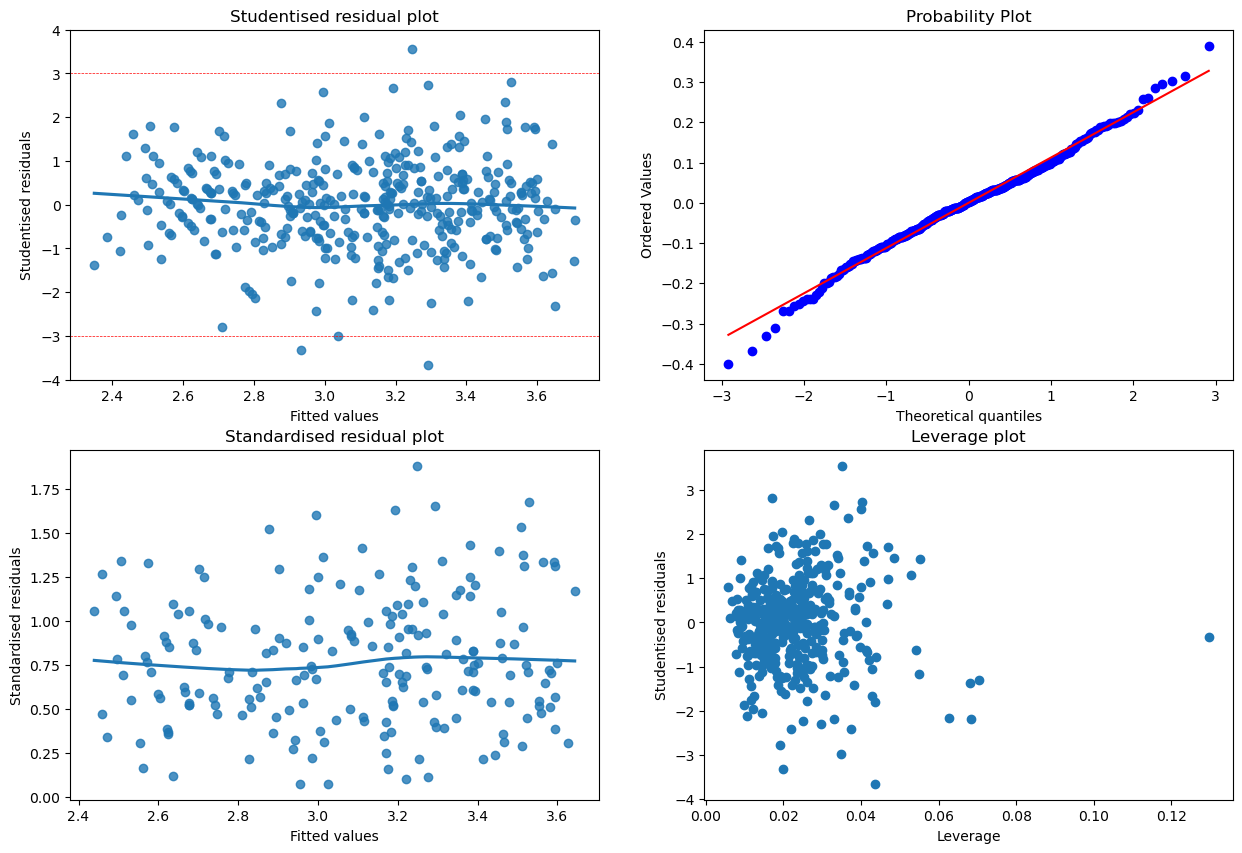

In [22]:
# Draw diagnostic plots
diag_plots(results_log_1)

It seems like taking the log of the response and predictors has decreased the pattern in the residuals. 

In [23]:
# Define the model formula
f_sqrt = 'mpg ~ np.sqrt(cylinders) + np.sqrt(displacement) + np.sqrt(horsepower) + np.sqrt(weight) + np.sqrt(acceleration) + np.sqrt(year) + C(origin) \
    + np.sqrt(cylinders*displacement) \
    + np.sqrt(cylinders*horsepower) \
    + np.sqrt(cylinders*weight) \
    + np.sqrt(cylinders*acceleration) \
    + np.sqrt(cylinders*year) \
    + np.sqrt(displacement*horsepower) \
    + np.sqrt(displacement*weight) \
    + np.sqrt(displacement*acceleration) \
    + np.sqrt(displacement*year) \
    + np.sqrt(horsepower*weight) \
    + np.sqrt(horsepower*acceleration) \
    + np.sqrt(horsepower*year) \
    + np.sqrt(weight*weight) \
    + np.sqrt(weight*acceleration) \
    + np.sqrt(weight*year) \
    + np.sqrt(acceleration*year)'

# Define the design matrix
y,X_sqrt = dmatrices(f_sqrt, df, return_type='dataframe')

# Define the model and fit
model_sqrt = sm.OLS(y,X_sqrt)
results_sqrt = model_sqrt.fit()

print(results_sqrt.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     116.6
Date:                Thu, 07 Mar 2024   Prob (F-statistic):          1.43e-155
Time:                        20:28:41   Log-Likelihood:                -938.88
No. Observations:                 392   AIC:                             1928.
Df Residuals:                     367   BIC:                             2027.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


c:\Users\User-PC\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


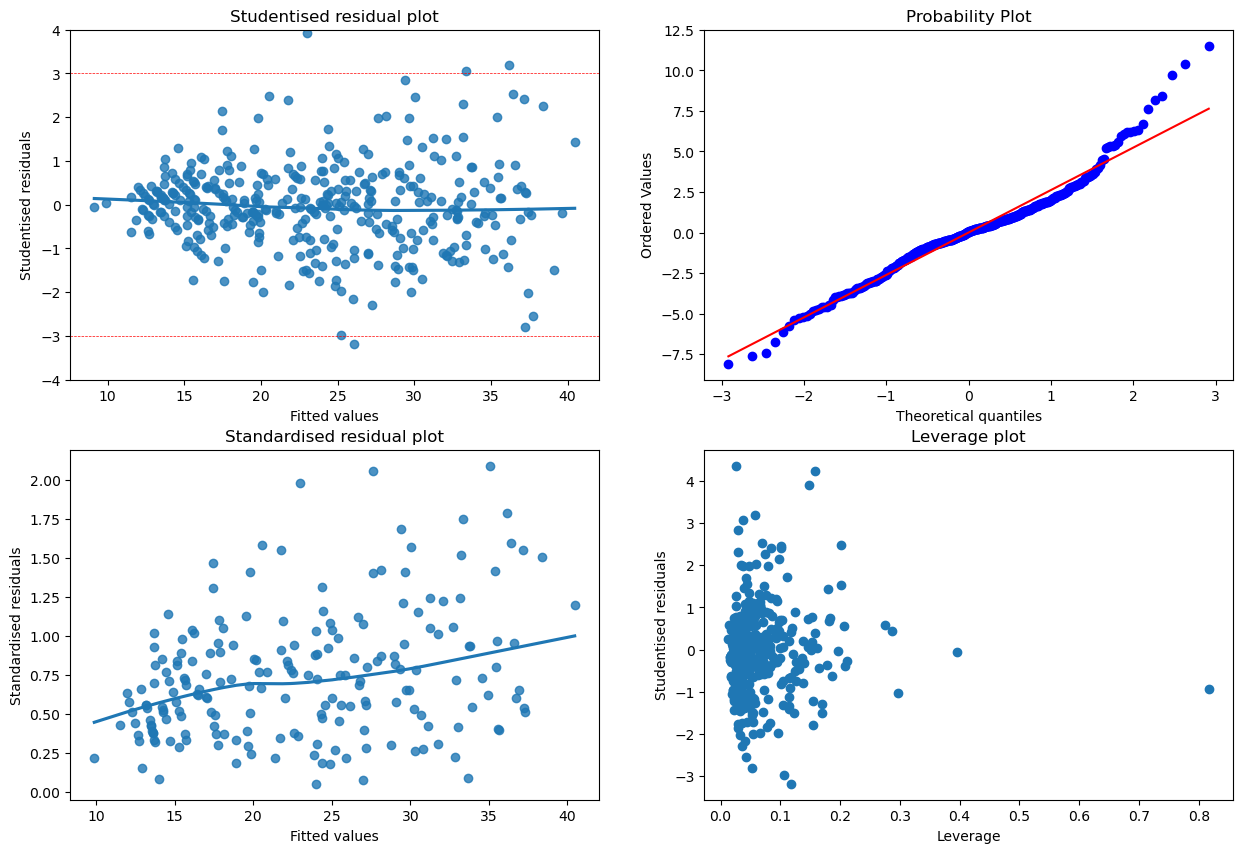

In [24]:
# Draw diagnostic plots
diag_plots(results_sqrt)

In [25]:
# Define the model formula
f_power2 = 'mpg ~ np.power(cylinders,2) + np.power(displacement,2) + np.power(horsepower,2) + np.power(weight,2) + np.power(acceleration,2) + np.power(year,2) + C(origin) \
    + np.power(cylinders*displacement,2) \
    + np.power(cylinders*horsepower,2) \
    + np.power(cylinders*weight,2) \
    + np.power(cylinders*acceleration,2) \
    + np.power(cylinders*year,2) \
    + np.power(displacement*horsepower,2) \
    + np.power(displacement*weight,2) \
    + np.power(displacement*acceleration,2) \
    + np.power(displacement*year,2) \
    + np.power(horsepower*weight,2) \
    + np.power(horsepower*acceleration,2) \
    + np.power(horsepower*year,2) \
    + np.power(weight*weight,2) \
    + np.power(weight*acceleration,2) \
    + np.power(weight*year,2) \
    + np.power(acceleration*year,2)'

# Define the design matrix
y,X_power2 = dmatrices(f_power2, df, return_type='dataframe')

# Define the model and fit
model_power2 = sm.OLS(y,X_power2)
results_power2 = model_power2.fit()

print(results_power2.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     137.5
Date:                Thu, 07 Mar 2024   Prob (F-statistic):          8.10e-158
Time:                        20:28:42   Log-Likelihood:                -943.80
No. Observations:                 392   AIC:                             1930.
Df Residuals:                     371   BIC:                             2013.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

c:\Users\User-PC\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


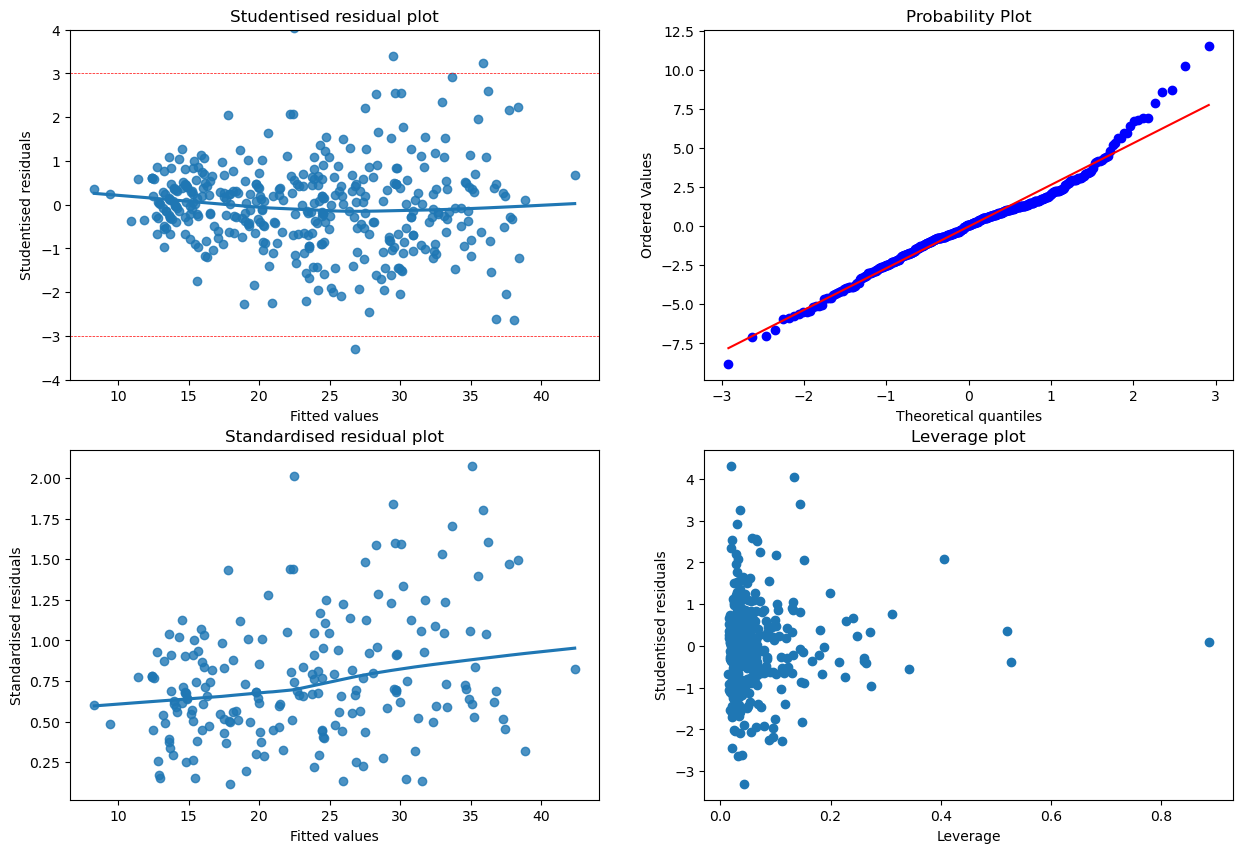

In [26]:
diag_plots(results_power2)

It seems like taking the log of all the predictors and responses worked the best. Let's see if we can improve the fit by dropping all predictors which p-values are greater than 0.05.

## 10. This question should be answered using the *Carseats* data set.

### (a) Fit a multiple linear regression model to predict *Sales* using *Price*, *Urban*, and *US*.

In [27]:
# Import the data
df_carseats = pd.read_csv(r'C:\Users\User-PC\Documents\GitHub\Introduction-to-Statistical-Learning\Data sets\Carseats.csv')

# Off with his head
df_carseats.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [28]:
# Change the qualitative values to qunatitative values
df_carseats['ShelveLoc_quant'] = np.where((df_carseats['ShelveLoc'] == 'Bad'), 1,np.where((df_carseats['ShelveLoc'] == 'Medium'), 2, 3))
df_carseats['Urban_quant'] = np.where((df_carseats['Urban'] == 'Yes'), 1,0)
df_carseats['US_quant'] = np.where((df_carseats['US'] == 'Yes'), 1,0)

df_carseats.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US,ShelveLoc_quant,Urban_quant,US_quant
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes,1,1,1
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes,3,1,1
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes,2,1,1
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes,2,1,1
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No,1,1,0


In [29]:
# Define the design matrix
f_carseats = 'Sales ~ Price + Urban_quant + US_quant'
y_carseats, X_carseats = dmatrices(f_carseats, data = df_carseats, return_type = 'dataframe')

# Create and fit the model
model_carseats = sm.OLS(y_carseats,X_carseats)
results_carseats = model_carseats.fit()

print(results_carseats.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     41.52
Date:                Thu, 07 Mar 2024   Prob (F-statistic):           2.39e-23
Time:                        20:28:43   Log-Likelihood:                -927.66
No. Observations:                 400   AIC:                             1863.
Df Residuals:                     396   BIC:                             1879.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      13.0435      0.651     20.036      

### (b) Provide an interpretation of each coefficient in the model. Be careful—some of the variables in the model are qualitative!

If the price increases with one unit, the sales decrease by 0.0545. There seems to be evidence to suggest that the store being in the US or not is statistically significant to the sales. If the store is in the US, we expect sales to be 1.2 times higher than the average. There does not seem to be evidence to suggest whether the store is in an urban environment has an influence on sales (p>0.05).

### (c) Write out the model in equation form, being careful to handle the qualitative variables properly.

y = -0.0545 x *Price* + 1.2006 x *US* - 0.0219 x *Urban* + 13.0435

Where *US* = {1 = Yes, 0 = No}

*Urban* = {1 = Yes, 0 = No}

### (d) For which of the predictors can you reject the null hypothesis H0 : $\beta$ $_j$ =0?

*Urban*, because the p-value is less than 0.05.

### (e) On the basis of your response to the previous question, fit a smaller model that only uses the predictors for which there is evidence of association with the outcome.

In [30]:
# Define the design matrix
f_carseats_final = 'Sales ~ Price + US_quant'
y_carseats_final, X_carseats_final = dmatrices(f_carseats_final, data = df_carseats, return_type = 'dataframe')

# Create and fit the model
model_carseats_final = sm.OLS(y_carseats_final,X_carseats_final)
results_carseats_final = model_carseats_final.fit()

print(results_carseats_final.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     62.43
Date:                Thu, 07 Mar 2024   Prob (F-statistic):           2.66e-24
Time:                        20:28:43   Log-Likelihood:                -927.66
No. Observations:                 400   AIC:                             1861.
Df Residuals:                     397   BIC:                             1873.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.0308      0.631     20.652      0.0

### (f) How well do the models in (a) and (e) fit the data?

c:\Users\User-PC\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


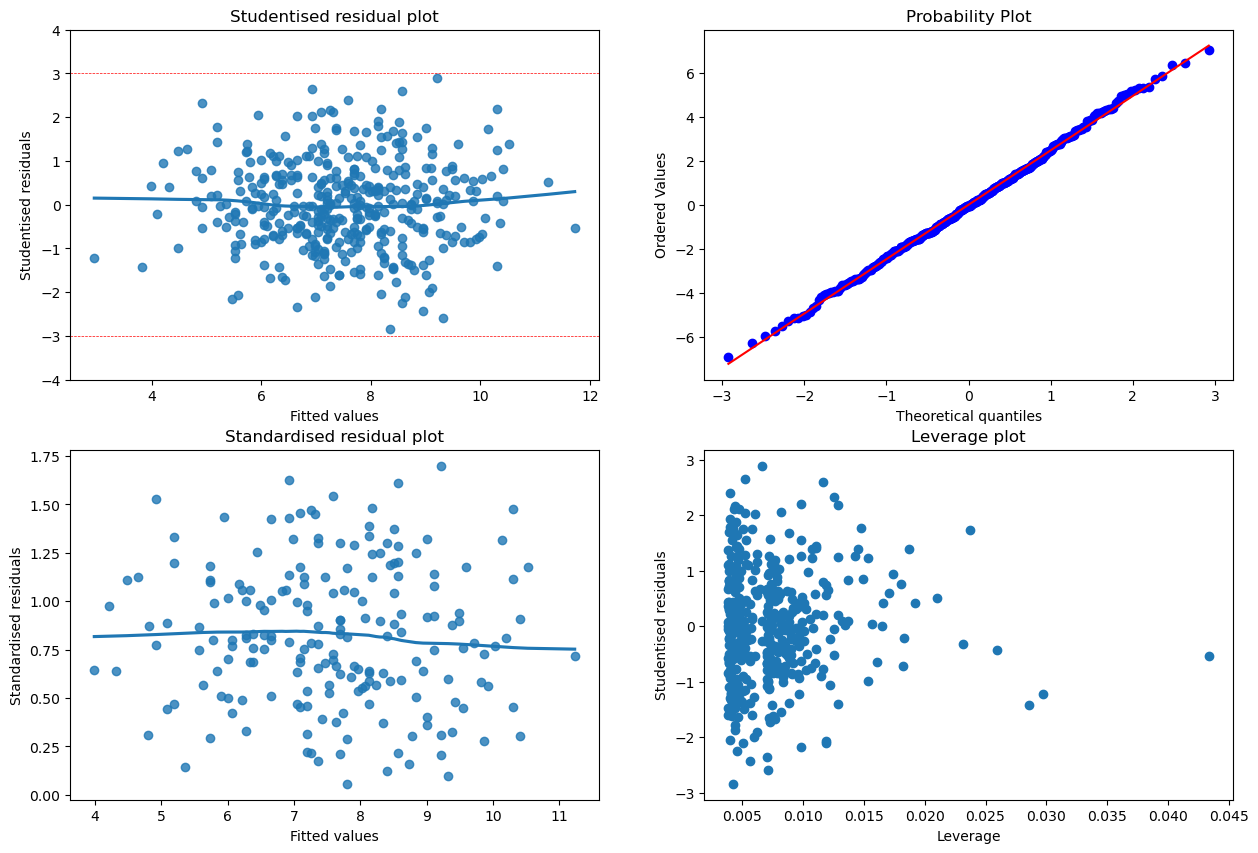

In [31]:
diag_plots(results_carseats_final)

There is almost no discernable pattern in the studentised residuals, the probability plot is almost perfect. There might be one observation causing some leverage, but it does not appear in the studentised plot as an outlier. 

The $R^2$ value is quite low at 0.239. The application of the model needs to be determined to evaluate if this is acceptable. 

### (g) Using the model from (e), obtain 95% confidence intervals for the coefficient(s).

In [32]:
# Get the 95% confidence intervals
conf_interv_95 = results_carseats_final.conf_int(alpha=0.05)

# Rename the columns
conf_interv_95.rename(index=str, columns ={0: "min.", 1: "max."})

,min.,max.
Intercept,11.79032,14.271265
Price,-0.06476,-0.044195
US_quant,0.69152,1.707766


### (h) Is there evidence of outliers or high leverage observations in the model from (e)?

There might be one observation causing some leverage, but it does not appear in the studentised plot as an outlier.


## 11. In this problem we will investigate the t-statistic for the null-hypothesis $H_0$ : \$beta$ = 0 in simple linear regressionwithout an intercept. To begin, we generate a predictor *x* and a response *y* as follows. 

In [33]:
rng = np.random.default_rng(1)
x = rng.normal(size=100)
y = 2*x + rng.normal(size=100)

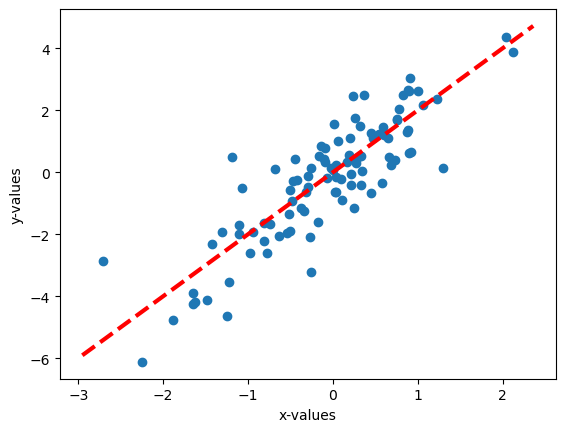

In [34]:
# Plot the data for a visual represention
fig, ax = plt.subplots()
ax.scatter(x=x, y=y)
ax.set_xlabel('x-values')
ax.set_ylabel('y-values')
abline(ax, 0, 2,'r--', linewidth = 3)

### (a) Perform a simple linear regression of y onto x, without an intercept. Report the coefficient estimate βˆ, the standard error of this coefficient estimate, and the t-statistic and p-value associated with the null hypothesis H0 : β = 0. Comment on these results.

In [35]:
# Define the function
f = 'y ~ x + 0'

# Create a dataframe to store the x and y values
df = pd.DataFrame({'x':x, 'y':y})

# Define the design matrices
y, X = dmatrices(f,df, return_type='dataframe')

# Define and fit the model
model = sm.OLS(y,X)
results = model.fit()

print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.743
Model:                            OLS   Adj. R-squared (uncentered):              0.740
Method:                 Least Squares   F-statistic:                              285.6
Date:                Thu, 07 Mar 2024   Prob (F-statistic):                    6.23e-31
Time:                        20:28:45   Log-Likelihood:                         -141.35
No. Observations:                 100   AIC:                                      284.7
Df Residuals:                      99   BIC:                                      287.3
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

The model slightly underestimates the coefficient (1.9762 versus the actual value of 2). However, the actual value is in the confidence intervals. The relationship between y and x are deemed statistically significant, since the p-value is less than 0.05, so the null-hypothesis was rejected.

### (b) Now perform a simple linear regression of x onto y without an intercept, and report the coefficient estimate, its standard error, and the corresponding t-statistic and p-values associated with the null hypothesis H0 : β = 0. Comment on these results.

In [36]:
# Define the function
f = 'x ~ y + 0'

# Define the design matrices
x, Y = dmatrices(f,df, return_type='dataframe')

# Define and fit the model
model = sm.OLS(x,Y)
results = model.fit()

print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      x   R-squared (uncentered):                   0.743
Model:                            OLS   Adj. R-squared (uncentered):              0.740
Method:                 Least Squares   F-statistic:                              285.6
Date:                Thu, 07 Mar 2024   Prob (F-statistic):                    6.23e-31
Time:                        20:28:45   Log-Likelihood:                         -58.349
No. Observations:                 100   AIC:                                      118.7
Df Residuals:                      99   BIC:                                      121.3
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

The coefficient is again underpredicted by the model (0.3757 versus the expected value of 0.5). Note: y = 2x, so x = 0.5y. The standard error is much lower than the previous result. The t-statistic is exactly the same.

### (c) What is the relationship between the results obtained in (a) and (b)?

The t-statistic is exactly the same. 

$\hat{y}$ = $\beta$ x + $\epsilon$

$\hat{x}$ = $\frac{y-\epsilon}{\beta}$

### (d) Using the results from (d), argue that the t-statistic for the regression of y onto x is the same as the t-statistic for the regression of x onto y.

